In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import textacy
import os
import codecs
import sys

from unicodedata import normalize

In [5]:
data_directory = os.path.join('.', 'data')
raw_excel_filepath = os.path.join(data_directory,
                                   'tag_data.xlsx')



pd.DataFrame()
df = pd.read_excel(raw_excel_filepath, header=1, encoding=sys.getfilesystemencoding(), 
                   names=['Description','Resolution','p_Item','p_Action','s_Action','s_Item'])


df.Description = df.Description.fillna('').apply(lambda x: x.replace('\n',' '))
df.Resolution = df.Resolution.fillna('').apply(lambda x: x.replace('\n',' '))
print df[['Description','Resolution']].iloc[34:37]
# df['RawText'] = df.Description.astype(str).str.cat(df.Resolution.astype(str, errors='ignore'), sep='. ')
df["RawText"] = df[['Description','Resolution']].apply(lambda x: '. '.join(x), axis=1)

def line_review(log):
    """
    un-escape the original line breaks in the text
    """
    log = log.replace('\\n', '\n')
    log = log.replace(' -', '; ')
    log = normalize('NFKD', unicode(log)).encode('ascii','ignore')
#     log = textacy.preprocess.fix_bad_unicode(log)
    return log

    
df.RawText = df.RawText.apply(line_review)

df = df[['RawText','p_Item','p_Action','s_Action','s_Item']]

raw_csv_filepath = os.path.join(data_directory,
                                   'raw_csv_tagged.csv')
# if not os.path.isfile(raw_csv_filepath): 
df.to_csv(raw_csv_filepath, header=False, encoding=sys.getfilesystemencoding())
df.head()

                                Description  \
34               St#12 HSK tool clamp loose   
35               Losing parts at exit chute   
36  Adjust jammed chip stripper on conveyor   

                                           Resolution  
34                           Replaced HSK clamp screw  
35               Operator adjusted chute -reported ok  
36  Adjusted chip conveyor belt tension and cleare...  


,RawText,p_Item,p_Action,s_Action,s_Item
0,No power. Replaced pin in pendant and powered ...,"pendant_cable, cable","short, no_power",replace,pin
1,Smartscope harness broken. Parts ordered / Tec...,smartscope_harness,broken,"order, repair",smartscope_harness
2,Check / Charge Accumulators. Where OK,accumulator,"check, charge",no_problem_detected,NaN
3,Hyd leak at saw atachment. Replaced seal in sa...,"hydraulic, saw_attachment, saw",leak,"replace, need_guy",seal
4,CS1008 setup change over / from ARC1004. Compl...,"cs1008, arc1004",setup_change,"complete, rewire",threading_unit


In [307]:
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')

content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  # Descriptions in Col 6
corpus = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)

corpus.add_texts()

Corpus(3438 docs; 49176 tokens)

In [308]:
corpus[0]

Doc(16 tokens; "No power. Replaced pin in pendant and powered m...")

In [309]:
# corpus.get()
# corpus[0].metadata
# train_corp = textacy.Corpus(u'en',docs=corpus.get(lambda x: x.metadata[4] != u''))
# train_corp
corpus.remove(lambda x: x.metadata[4] == u'')
corpus

Corpus(1042 docs; 14689 tokens)

In [310]:
def get_corpus_embedding(corpus, vec_type = 'lsa', n_topics=30):

    if vec_type == 'lda':
        doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
            (doc.to_terms_list(ngrams=(1,2,3), 
                               normalize=u'lemma',
                               named_entities=True, 
                               filter_stops=True,
                               filter_punct=True,
                               as_strings=True)
                for doc in corpus),
            weighting='tf', 
            normalize=False, 
            smooth_idf=False, 
            min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs
        model = textacy.tm.TopicModel('lda', n_topics=n_topics)
        model.fit(doc_term_matrix)
        doc_topic_matrix = model.transform(doc_term_matrix)    

    elif vec_type == 'w2v':
        return (corpus.vectors, None)
    
    else:
        doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
            (doc.to_terms_list(ngrams=(1,2,3), 
                               normalize=u'lemma',
                               named_entities=True, 
                               filter_stops=True,
                               filter_punct=True,
                               as_strings=True)
                for doc in corpus),
            weighting='tfidf', 
            normalize=True, 
            smooth_idf=True, 
            min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs
        
        if vec_type == 'nmf':
            model = textacy.tm.TopicModel('nmf', n_topics=n_topics)
            model.fit(doc_term_matrix)
            doc_topic_matrix = model.transform(doc_term_matrix)
            
        else:
            model = textacy.tm.TopicModel('lsa', n_topics=n_topics)
            model.fit(doc_term_matrix)
            doc_topic_matrix = model.transform(doc_term_matrix)
            
    print(repr(doc_term_matrix))        
    return model, doc_topic_matrix, id2term, doc_term_matrix


    

In [322]:
model, X_topics, id2term, term = get_corpus_embedding(corpus, vec_type='lda', n_topics=15)

<1042x1580 sparse matrix of type '<type 'numpy.int32'>'
	with 11871 stored elements in Compressed Sparse Row format>


In [323]:
print "Doc. Matrix Shape: ", X_topics.shape

for topic_idx, top_terms in model.top_topic_terms(id2term, top_n=5):
    print('topic', topic_idx, ':', '   '.join(top_terms))

Doc. Matrix Shape:  (1042L, 15L)
('topic', 0, ':', u'bar   replace   load   feed   fault')
('topic', 1, ':', u'screw   see   remove   replace   clamp')
('topic', 2, ':', u'table   reset   breaker   fault   adjust')
('topic', 3, ':', u'inop   replace   hydraulic   conveyor   hose')
('topic', 4, ':', u'charge   accumulator   charge accumulator   rotator   check')
('topic', 5, ':', u'replace   fuse   operator   level   replaced')
('topic', 6, ':', u'repair   broken   feeder   chain   bar')
('topic', 7, ':', u'air   b   base drain   b hydraulic   pneumatic')
('topic', 8, ':', u'chip   conveyor   chip conveyor   jam   clutch')
('topic', 9, ':', u'loader   bar loader   bar   base   clean')
('topic', 10, ':', u'accumulator   charge   check   30bar   accumulator check')
('topic', 11, ':', u'switch   need   new   p/p   replace')
('topic', 12, ':', u'valve   replace   o   hydraulic   ring')
('topic', 13, ':', u'hydraulic   replace   leak   inverter   unit')
('topic', 14, ':', u'unit   brush   br

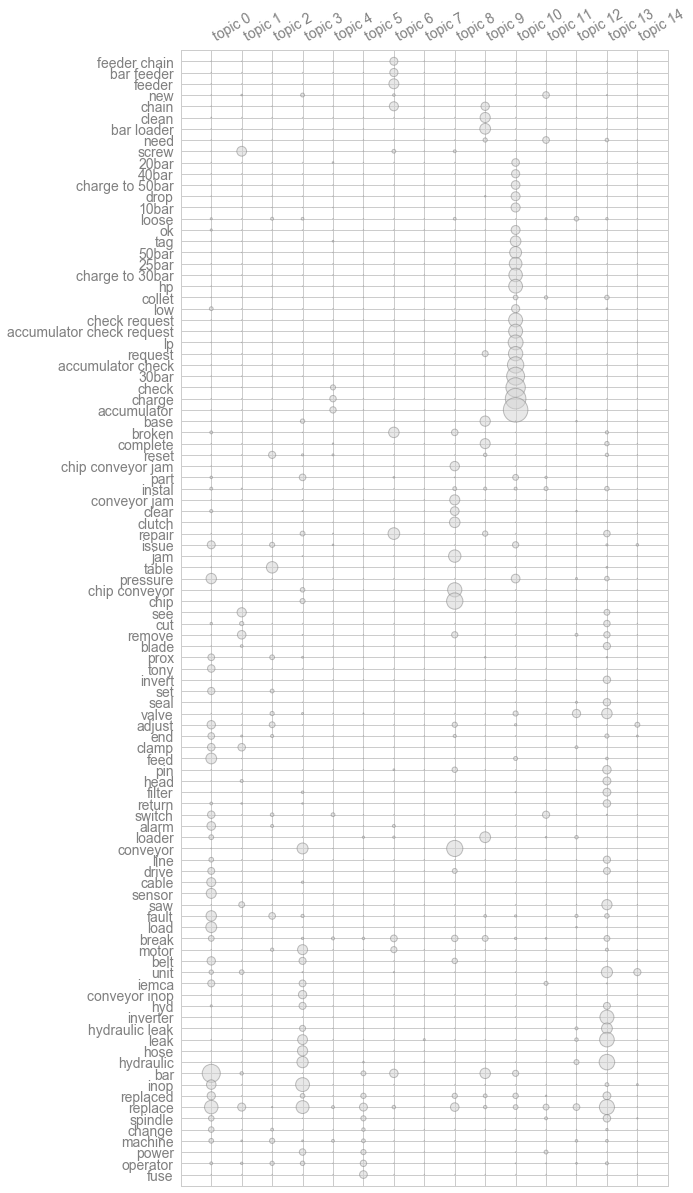

In [324]:
model.termite_plot(term, id2term, n_terms=100, sort_terms_by='seriation')

In [325]:
s_act_mask = df.s_Action.notnull().values

In [326]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(X_topics) 
# tsne_lda = tsne_model.fit_transform(corpus.vectors) 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1042
[t-SNE] Computed conditional probabilities for sample 1042 / 1042
[t-SNE] Mean sigma: 0.024573
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.452123
[t-SNE] Error after 200 iterations: 0.452123


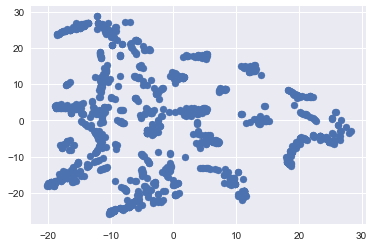

In [327]:
plt.scatter(tsne_lda[:,0],tsne_lda[:,1])

In [328]:
n_top_words = 5 # number of keywords we show

# # -----------
# threshold = 0.5
# _idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
# X_topics = X_topics[_idx]
# tsne_lda = tsne_lda[_idx]
# # -----------

# most likely topic 
_lda_keys = []
for i in xrange(X_topics.shape[0]):
    _lda_keys += X_topics[i].argmax(),

# top words for each topic
topic_summaries = []
for topic_idx, top_terms in model.top_topic_terms(id2term, top_n=n_top_words):
    topic_summaries.append(str(', '.join(top_terms)))
topic_summaries

['bar, replace, load, feed, fault',
 'screw, see, remove, replace, clamp',
 'table, reset, breaker, fault, adjust',
 'inop, replace, hydraulic, conveyor, hose',
 'charge, accumulator, charge accumulator, rotator, check',
 'replace, fuse, operator, level, replaced',
 'repair, broken, feeder, chain, bar',
 'air, b, base drain, b hydraulic, pneumatic',
 'chip, conveyor, chip conveyor, jam, clutch',
 'loader, bar loader, bar, base, clean',
 'accumulator, charge, check, 30bar, accumulator check',
 'switch, need, new, p/p, replace',
 'valve, replace, o, hydraulic, ring',
 'hydraulic, replace, leak, inverter, unit',
 'unit, brush, brush unit, adjust, russ']

In [329]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    AUTHOR: Gabriel, https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


In [332]:
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool, LabelSet, Range1d


# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f"
#     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])
title = 'Greystone Maintainance Topics - LDA'
num_example = len(X_topics)

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave,lasso_select",
                     x_axis_type=None, y_axis_type=None, min_border=1,
                     x_range=Range1d(tsne_lda[:, 0].min(), tsne_lda[:, 0].max()),
                     y_range=Range1d(tsne_lda[:, 1].min(), tsne_lda[:, 1].max())
                    )

src = bp.ColumnDataSource({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    "content": [x.text for x in corpus],
    "topic_key": _lda_keys[:num_example],
    "color": colormap[_lda_keys][:num_example]
})

plot_lda.scatter(x='x', y='y',
                 color="color",
                 source=src, size=10)
topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
        break
#     topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]
    topic_coord[topic_num] = np.median(tsne_lda[np.where(np.array(_lda_keys)==topic_num)],axis=0)

# vor = Voronoi(topic_coord)
# regions, vertices = voronoi_finite_polygons_2d(vor)
# xs = [vertices[region][:,0].tolist() for region in regions]
# ys = [vertices[region][:,1].tolist() for region in regions]

lab_src = bp.ColumnDataSource(data=dict(x = topic_coord[:, 0],
                                        y = topic_coord[:, 1],
#                                         topic_x = xs,
#                                         topic_y = ys,
                                        topic_key = topic_summaries,
                                        content = np.unique(_lda_keys, return_counts=True)[1],
                                        color = colormap.tolist()))

# plot_lda.patches('topic_x', 'topic_y', source=lab_src, alpha=.1, color='color')

labels = LabelSet(x='x', y='y', text='topic_key', level='glyph',
                  y_offset=5, source=lab_src,
                  render_mode='canvas', text_align='center', text_alpha=.8,
                  background_fill_color='white', background_fill_alpha=.4)
# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content", 'topic': "@topic_key"}
plot_lda.add_layout(labels)
# save the plot
save(plot_lda, '{}.html'.format(title))

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\bokeh\models\sources.py:89: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


'Z:\\My Documents\\Projects\\DiagnosticKB\\MaintenanceLanguageProcessing\\Greystone Maintainance Topics - LDA.html'

In [333]:
topn = 1000
topn_tok = [str(id2term[i]) for i in term.sum(axis=0).argsort()[0,-topn:].tolist()[0][::-1]]
with open('top{}.txt'.format(topn), 'w') as f:
    for i in topn_tok:
        f.write(i+'\n')
# topn_tok
# id2term
# textacy.keyterms.aggregate_term_variants(corpus[0].terms)

In [334]:
# from itertools import chain
# terms_list = list(chain(*[i.to_terms_list(as_strings=True, 
#                                           filter_stops=True, 
#                                           filter_punct=True) for i in corpus]))

agg = textacy.keyterms.aggregate_term_variants(set(topn_tok))
agg

[{u'accumulator check', 'accumulator check request', u'check request'},
 {u'hydraulic motor', 'hydraulic motor overload', u'motor overload'},
 {u'connection repair', u'loose connection', 'loose connection repair'},
 {u'motor contactor', u'replace motor', 'replace motor contactor'},
 {u'bearing replace', u'spindle bearing', 'spindle bearing replace'},
 {u'hydraulic hose', u'rupture hydraulic', 'rupture hydraulic hose'},
 {u'replace hydraulic', 'replace hydraulic hose'},
 {u'broken clutch', u'replaced broken', 'replaced broken clutch'},
 {u'replace see', 'replace see attachment', u'see attachment'},
 {u'leak hydraulic', u'spindle leak', 'spindle leak hydraulic'},
 {u'conveyor inop', u'offload conveyor', 'offload conveyor inop'},
 {u'part offload', 'part offload conveyor'},
 {u'hydraulic return', 'hydraulic return line', u'return line'},
 {u'selector switch', 'selector switch break', u'switch break'},
 {u'change overtime', 'change overtime fault', u'overtime fault'},
 {u'control valve', u

In [352]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier

s_actions = [i.metadata[3].split(', ') for i in corpus]

print s_actions[1]

multi_bin =  MultiLabelBinarizer().fit(s_actions)
Y_train = multi_bin.transform(s_actions)
print Y_train[1]

[u'order', u'repair']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


using all classes (1042L, 91L)
using non-unique classes (1025L, 50L)


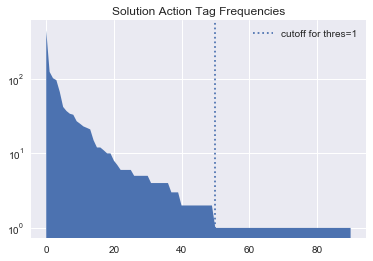

In [342]:
# print 'using all classes', Y_temp.shape
# # print np.sort(Y_temp.sum(axis=0))[::-1]
# plt.fill_between(range(Y_temp.shape[1]), np.sort(Y_temp.sum(axis=0))[::-1])
# plt.yscale('log')
# thres = 1
# plt.title('Solution Action Tag Frequencies')
# used_classes = multi_bin.classes_[Y_temp.sum(axis=0)>thres]
# s_act_thres = pd.Series([[i for i in s if i in used_classes] for s in s_actions])
# mask = [i!=list([]) for i in s_act_thres.values]
# s_act_thres = s_act_thres[mask]
# binlab = MultiLabelBinarizer().fit(s_act_thres)
# Y_train = binlab.transform(s_act_thres)
# plt.axvline(Y_train.shape[1], ls=':', label='cutoff for thres={}'.format(thres))
# plt.legend()
# print 'using non-unique classes', Y_train.shape

In [413]:
clf = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ))
clf.fit(corpus.vectors, Y_train)
print clf.score(corpus.vectors, Y_train)
print 'Score: {:.2f}\t Hamming Loss: {:.2E}'.format(clf.score(corpus.vectors, Y_train), 
                                                    hamming_loss(Y_train, clf.predict(corpus.vectors))) 
# multi_bin.inverse_transform(clf.predict(X_topics))

0.691938579655
Score: 0.69	 Hamming Loss: 4.38E-03


In [420]:
pd.DataFrame(data={'Pred':[str(', '.join(i)) for i in multi_bin.inverse_transform(clf.predict(corpus.vectors))],
             'True':[str(', '.join(i)) for i in multi_bin.inverse_transform(Y_train)]})

,Pred,True
0,replace,replace
1,"order, repair","order, repair"
2,replace,"need_guy, replace"
3,complete,"complete, rewire"
4,"remove, swap","remove, replace"
5,"charge, check","charge, check"
6,repair,repair
7,replace,replace
8,"clean, remove","clean, remove"
9,replace,replace


In [418]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

in_tags = [i.metadata[1].split(', ') + i.metadata[2].split(', ') for i in corpus]
print in_tags[0]
multi_in = MultiLabelBinarizer()
X_tags = multi_in.fit_transform(in_tags)


clf2 = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ))
pipe = Pipeline([
    ('reduce', TruncatedSVD(n_components=250)),
    ('classify', clf2)
])

pipe.fit(X_tags, Y_train)
print 'Score: {:.2f}\t Hamming Loss: {:.2E}'.format(pipe.score(X_tags, Y_train), 
                                                    hamming_loss(Y_train, pipe.predict(X_tags))) 
# multi_bin.inverse_transform(clf.predict(X_tags))

[u'pendant_cable', u'cable', u'short', u'no_power']
Score: 0.51	 Hamming Loss: 7.92E-03


In [419]:
pd.DataFrame(data={'Pred':[str(', '.join(i)) for i in multi_bin.inverse_transform(pipe.predict(X_tags))],
             'True':[str(', '.join(i)) for i in multi_bin.inverse_transform(Y_train)]})

,Pred,True
0,replace,replace
1,,"order, repair"
2,replace,"need_guy, replace"
3,"complete, rewire","complete, rewire"
4,,"remove, replace"
5,charge,"charge, check"
6,repair,repair
7,replace,replace
8,replace,"clean, remove"
9,,replace


In [403]:
from sklearn.metrics import hamming_loss
print hamming_loss(Y_train, pipe.predict(X_tags)) 
print hamming_loss(Y_train, clf.predict(corpus.vectors))

0.00818375482483
0.00465081943009


In [424]:
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')
content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  # Descriptions in Col 6
corpus_new = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)
corpus_new

Corpus(3438 docs; 49176 tokens)

In [430]:
corpus_new.remove(lambda x: x.metadata[3] != u'')

In [434]:
pd.DataFrame(data={'PredActionSol':[str(', '.join(i)) for i in multi_bin.inverse_transform(clf.predict(corpus_new.vectors))],
             'RawText': [i.text for i in corpus_new]}).to_excel('SGD_W2V_multLab.xlsx')